In [13]:
!pip install matplotlib
import matplotlib.pyplot as plt

In [ ]:
!pip install keras==2.2.4
!pip install  segmentation-models


     |████████████████████████████████| 312 kB 4.7 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 737 kB 107.2 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.9.1
    Uninstalling keras-3.9.1:
      Successfully uninstalled keras-3.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires keras>=3.5.0, but you have keras 2.2.4 which is incompatible.


In [11]:
# Add these imports before importing segmentation_models
import keras.utils as utils
import keras.backend as K
import keras.models as models
import keras.layers as layers
utils.generic_utils = utils

Using TensorFlow backend.


In [12]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam  # Correct way in TF 2.x
import segmentation_models as sm


bf_dir = "./final_bf"
gt_dir = "./final_edge_detected"
image_size = (256, 256)

bf_images = sorted([os.path.join(bf_dir, f) for f in os.listdir(bf_dir) if f.endswith('.png')])
gt_images = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.png')])

assert len(bf_images) == len(gt_images), "Number of images and masks do not match"

random_seed = 42
np.random.seed(random_seed)

# Train-test split (80% training, 20% testing)
train_bf, test_bf, train_gt, test_gt = train_test_split(bf_images, gt_images, test_size=0.2, random_state=random_seed)

def load_image(image_path, size=image_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = cv2.resize(image, size)
    image = np.stack((image,) * 3, axis=-1)  # Convert to 3 channels (if needed)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_mask(mask_path, size=image_size):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size)
    mask = mask / 255.0  # Normalize to [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return mask

X_train = np.array([load_image(img_path) for img_path in train_bf])
y_train = np.array([load_mask(mask_path) for mask_path in train_gt])

# Load testing images and masks
X_test = np.array([load_image(img_path) for img_path in test_bf])
y_test = np.array([load_mask(mask_path) for mask_path in test_gt])

print(f'Training Images: {X_train.shape}, Training Masks: {y_train.shape}')
print(f'Testing Images: {X_test.shape}, Testing Masks: {y_test.shape}')

# Define the backbone you want to use
BACKBONE = 'resnet34'  # You can also try 'resnet50', 'efficientnetb0', etc.
preprocess_input = sm.get_preprocessing(BACKBONE)

# Preprocess your images (assuming you have already preprocessed your images in the previous step)
X_train = np.array([preprocess_input(img) for img in X_train])
X_test = np.array([preprocess_input(img) for img in X_test])

# Load the pretrained U-Net model
model = sm.Unet(BACKBONE, 
                encoder_weights='imagenet',  # Pre-trained on ImageNet
                input_shape=(256, 256, 3),   # Match your input image size
                classes=1,                   # Binary segmentation
                activation='sigmoid')        # Use 'softmax' if doing multi-class segmentation

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()  # View the model architecture

Segmentation Models: using `keras` framework.
Training Images: (814, 256, 256, 3), Training Masks: (814, 256, 256, 1)
Testing Images: (204, 256, 256, 3), Testing Masks: (204, 256, 256, 1)


W0000 00:00:1743371467.099472 2480733 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


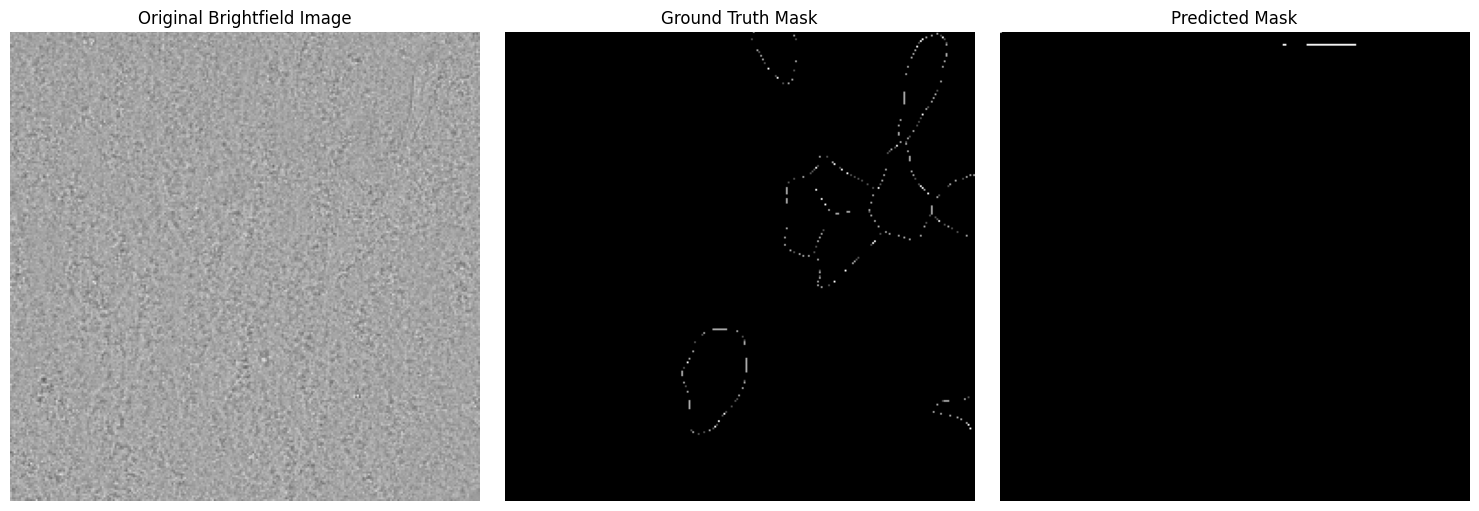

In [33]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pick a random test image
random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]
test_mask = y_test[random_index]

# Make prediction
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Convert predicted mask to binary (thresholding)
threshold = 0.5
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(test_image, cmap='gray')  # Ensure proper visualization
plt.title('Original Brightfield Image')
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(test_mask), cmap='gray')  # Squeeze if necessary
plt.title('Ground Truth Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray')  # Squeeze for proper display
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.metrics import MeanIoU

# Evaluate on the test set
evaluation = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Compute Mean IoU
num_classes = 2  # Background and Edge Detected Mask
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(y_test, (model.predict(X_test) > threshold).astype(np.uint8))
print(f"Mean IoU = {IOU_keras.result().numpy()}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 924ms/step - accuracy: 0.9902 - loss: 0.4852
Test Loss: 0.4851360321044922
Test Accuracy: 0.9904188513755798
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step
Mean IoU = 0.4997395873069763


In [1]:
import torch
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
url = pmm.util.get_pretrained_microscopynet_url('resnet50', 'micronet')
model.load_state_dict(model_zoo.load_url(url))
model.eval()  # <- MicrosNet model for classifcation or transfer learning

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/suriya/.cache/torch/hub/v0.10.0.zip
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar" to /home/suriya/.cache/torch/hub/checkpoints/resnet50_pretrained_microscopynet_v1.1.pth.tar
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
import pretrained_microscopy_models as pmm

# setup a UNet model with a ResNet50 backbone.
model = pmm.segmentation_training.create_segmentation_model('Unet', 'resnet50', 'micronet', classes=3)

# See examples to train and make predictions with model.


Training Images: (814, 256, 256, 3), Training Masks: (814, 256, 256, 1)
Testing Images: (204, 256, 256, 3), Testing Masks: (204, 256, 256, 1)


Using cache found in /home/suriya/.cache/torch/hub/pytorch_vision_v0.10.0
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted Class: 33


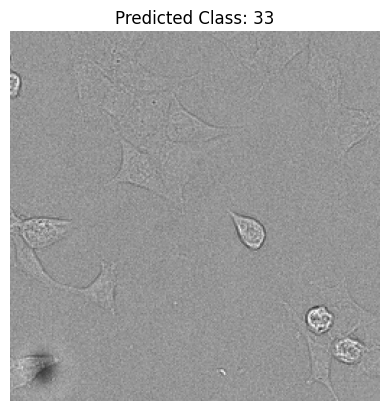

In [6]:
import torch
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from sklearn.model_selection import train_test_split

bf_dir = "./final_bf"
gt_dir = "./final_edge_detected"
image_size = (256, 256)

bf_images = sorted([os.path.join(bf_dir, f) for f in os.listdir(bf_dir) if f.endswith('.png')])
gt_images = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.png')])

assert len(bf_images) == len(gt_images), "Number of images and masks do not match"

random_seed = 42
np.random.seed(random_seed)

# Train-test split (80% training, 20% testing)
train_bf, test_bf, train_gt, test_gt = train_test_split(bf_images, gt_images, test_size=0.2, random_state=random_seed)

def load_image(image_path, size=image_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = cv2.resize(image, size)
    image = np.stack((image,) * 3, axis=-1)  # Convert to 3 channels (if needed)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_mask(mask_path, size=image_size):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size)
    mask = mask / 255.0  # Normalize to [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return mask

X_train = np.array([load_image(img_path) for img_path in train_bf])
y_train = np.array([load_mask(mask_path) for mask_path in train_gt])

# Load testing images and masks
X_test = np.array([load_image(img_path) for img_path in test_bf])
y_test = np.array([load_mask(mask_path) for mask_path in test_gt])

print(f'Training Images: {X_train.shape}, Training Masks: {y_train.shape}')
print(f'Testing Images: {X_test.shape}, Testing Masks: {y_test.shape}')

# Load the pretrained ResNet50 model from MicroscopyNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
url = pmm.util.get_pretrained_microscopynet_url('resnet50', 'micronet')  # Get the pretrained weights URL
model.load_state_dict(model_zoo.load_url(url))  # Load the pretrained weights
model.eval()  # Set the model to evaluation mode

# Example: Use the model for classification or transfer learning
# Assuming `X_test` is your test dataset and `y_test` is the ground truth

# Pick a random test image
random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]

# Preprocess the test image for ResNet50
test_image_tensor = torch.tensor(test_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
test_image_tensor = test_image_tensor.permute(0, 3, 1, 2)  # Convert to (N, C, H, W) format if needed

# Make prediction
with torch.no_grad():
    prediction = model(test_image_tensor)

# Process the prediction (e.g., classification or segmentation)
# For classification, you can use `torch.argmax` to get the predicted class
predicted_class = torch.argmax(prediction, dim=1).item()

# Print the predicted class
print(f"Predicted Class: {predicted_class}")

# Visualization (if applicable)
plt.imshow(test_image, cmap='gray')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pick a random test image
random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]
test_mask = y_test[random_index]  # Ground truth mask

# Preprocess the test image (if necessary)
test_image_input = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Make prediction
predicted_mask = model.predict(test_image_input)[0]  # Remove batch dimension from prediction

# Convert predicted mask to binary (thresholding)
threshold = 0.5
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(test_image, cmap='gray')  # Ensure proper visualization
plt.title('Original Brightfield Image')
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(test_mask), cmap='gray')  # Squeeze if necessary
plt.title('Ground Truth Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray')  # Squeeze for proper display
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

AttributeError: 'ResNet' object has no attribute 'predict'